In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import lightgbm 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

%matplotlib inline
import numpy as np

In [0]:
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, LambdaCallback
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

In [0]:
def flatten (n):
    org =[]
    for i in n :
        if (isinstance(i,list)):
            org += flatten(i)
        else:
            org.append(i)
    return org

In [0]:
caltech_dir = '/content/gdrive/My Drive/competition/train'
categories = ['0', '1', '2', '3', '4', '5']
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X= []
Y = []

for idx, cat in enumerate(categories):
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    
    image_dir = caltech_dir + '/' + cat
    files = glob.glob(image_dir + '/*.jpg')
    print(cat, '파일 길이: ', len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert('RGB')
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        
        X.append(data)
        Y.append(label)

0 파일 길이:  2512
1 파일 길이:  2382
2 파일 길이:  2404
3 파일 길이:  2191
4 파일 길이:  2274
5 파일 길이:  1411


In [0]:
test_dir = '/content/gdrive/My Drive/competition/test'


image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X_test= []


    

files = glob.glob(test_dir + '/*.jpg')
print(cat, '파일 길이: ', len(files))
for i, f in enumerate(files):
      img = Image.open(f)
      img = img.convert('RGB')
      img = img.resize((image_w, image_h))
      data = np.asarray(img)
        
      X_test.append(data)
        

5 파일 길이:  3000


In [0]:
#새로운 image 추가
for i in range(len(X)):
    blur = cv2.GaussianBlur(X[i], (5, 5), 0)
    X.append(blur)
    Y.append(Y[i])


In [0]:
#윤곽선 image 추가
sure = [0] * len(X)
for i in range(len(X)):
    gray = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


    sure_bg = cv2.dilate(opening, kernel, iterations=3)


    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.001 * dist_transform.max(), 255, 0)


    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    sure_fg = np.array(sure_fg)
    
    sure_fg = cv2.resize(sure_fg, (64, 64))
    sure[i] = sure_fg

In [0]:
X1 = [0] * len(X)
for a in range(len(X)):
    X_hat = [[X[a][i][j].tolist(), sure[a][i][j]] for j in range(64) for i in range(64)]
    for i in range(4096):
        X_hat[i] = flatten(X_hat[i])
    X1[a] = X_hat

In [0]:
X1= np.array(X1)

In [0]:
X1 = X1.reshape(-1, 64, 64, 4)

In [0]:
len(X)

26348

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X1,Y, test_size = 0.25,
                                                  random_state = 123457)

Y_hat_train = []
Y_hat_val = []
for i in range(len(Y_train)):
  if Y_train[i] == [0, 1, 0, 0, 0, 0] or Y_train[i] == [0, 0, 0, 1, 0, 0]:
    Y_hat_train.append([0, 1])
    
  else:
    Y_hat_train.append([1,0])

for i in range(len(Y_val)):
  if Y_val[i] == [0, 1, 0, 0, 0, 0] or Y_val[i] == [0, 0, 0, 1, 0, 0]:
    Y_hat_val.append([0,1])
  else:
    Y_hat_val. append([1,0])

X_train = np.array(X_train)
X_val = np.array(X_val)
Y_hat_train = np.array(Y_hat_train)
Y_hat_val = np.array(Y_hat_val)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)


In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [0]:
#도시, 자연 이미지 분류
input = Input(shape=(64, 64, 4))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')
x = model.output
x = Dense(2, activation='softmax', name='softmax')(x)
model = Model(model.input, x)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 4)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   12608       conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model.compile(loss='binary_crossentropy',
                  #optimizer=optimizers.RMSprop(lr=2e-4),
                  optimizer=optimizers.adam(lr=0.0001),
                  metrics=['acc'])

In [0]:
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(model.layers[3].get_weights()))
early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_loss')

In [0]:
history = model.fit_generator(datagen.flow(X_train,Y_hat_train, batch_size=64),
        epochs = 45, steps_per_epoch = X_train.shape[0]//64,  
        validation_data = (X_val,Y_hat_val), verbose=0, callbacks = [early_stopping, print_weights])

ValueError: ignored

In [0]:
scores = model.evaluate_generator(datagen.flow(X_val,Y_hat_val, batch_size=64), steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

acc: 94.06%


In [0]:


from keras.models import load_model
model.save('/content/gdrive/My Drive/nature_city_binary2.h5')

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/nature_city_binary.h5')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
Train_results = np.argmax(model.predict(X_train), axis = 1)
Val_results = np.argmax(model.predict(X_val), axis = 1)


In [0]:
  from sklearn.metrics import accuracy_score
  score = accuracy_score(np.argmax(Y_hat_val, axis = 1), Val_results)
  score

0.9180327868852459

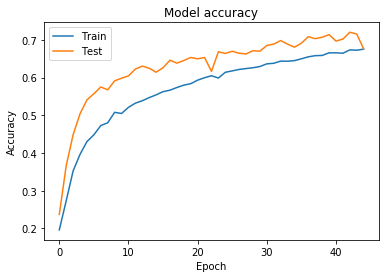

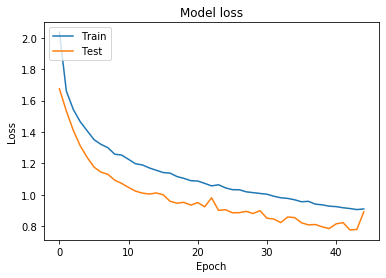

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
Y2_train = np.argmax(Y_hat_train, axis = 1)
Y2_val = np.argmax(Y_hat_val, axis = 1)

In [0]:
Nature_X_train = []
Nature_Y_train = []
Nature_X_val = []
Nature_Y_val = []
City_X_train = []
City_Y_train = []
City_X_val = []
City_Y_val = []
for i in range(len(Y2_train)):
  if Y2_train[i] == 1:
    City_X_train.append(X_train[i])
    City_Y_train.append(Y_train[i])
  else:
    Nature_X_train.append(X_train[i])
    Nature_Y_train.append(Y_train[i])

for i in range(len(Y2_val)):
  if Y2_val[i] == 1:
    City_X_val.append(X_val[i])
    City_Y_val.append(Y_val[i])
  else:
    Nature_X_val.append(X_val[i])
    Nature_Y_val.append(Y_val[i])

In [0]:
len(City_X_train) + len(City_X_val)

4573

In [0]:
Nature_Y_train = np.array(Nature_Y_train)
Nature_X_train = np.array(Nature_X_train)
Nature_X_val = np.array(Nature_X_val)
Nature_Y_val = np.array(Nature_Y_val)
City_Y_train = np.array(City_Y_train)
City_X_train = np.array(City_X_train)
City_X_val = np.array(City_X_val)
City_Y_val = np.array(City_Y_val)

In [0]:
#자연 분류 모델
input = Input(shape=(224, 224, 3))
model0 = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x0 = model0.output
x0 = Dense(1024, name='fully', init='uniform')(x0)
x0 = BatchNormalization()(x0)
x0 = Activation('relu')(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(512, init='uniform')(x0)
x0 = BatchNormalization()(x0)
x0 = Activation('relu')(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(4, activation='softmax', name='softmax')(x0)
model0 = Model(model0.input, x0)
model0.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, name="fully", kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform")`
  if __name__ == '__main__':


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
model0.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-4),
                  #optimizer=optimizers.adam(),
                  metrics=['acc'])

In [0]:
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(model0.layers[3].get_weights()))
early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_loss')
history0 = model0.fit_generator(datagen.flow(Nature_X_train,Nature_Y_hat_train, batch_size=64),
        epochs = 60, steps_per_epoch = Nature_X_train.shape[0]//224,  
        validation_data = (Nature_X_val,Nature_Y_hat_val), verbose=0, callbacks = [early_stopping, print_weights])

[array([1.0010341 , 0.99961996, 1.001755  , 0.999189  , 0.9993568 ,
       1.0015428 , 1.0008668 , 1.0010263 , 0.99898136, 1.0004345 ,
       1.0001667 , 0.9991819 , 1.0009987 , 1.0003122 , 1.0010874 ,
       0.9989228 , 0.9976909 , 1.00246   , 0.99845266, 0.99957603,
       0.99875534, 0.9998643 , 0.9994923 , 0.99884194, 1.0023232 ,
       1.0011461 , 0.99920505, 0.9975733 , 1.0007703 , 1.0000739 ,
       1.0004665 , 1.0022568 , 0.9999031 , 0.9996847 , 1.0002943 ,
       1.0005912 , 1.0007704 , 1.0013671 , 0.99881154, 1.0021615 ,
       1.0004724 , 0.99945515, 0.99961746, 0.99860126, 1.0008622 ,
       1.0008649 , 1.0010325 , 0.9979206 , 1.0014638 , 0.9988854 ,
       0.9986707 , 0.9996073 , 0.99757123, 0.998188  , 1.0000517 ,
       0.999506  , 1.0007894 , 0.99946713, 1.0006872 , 1.0021331 ,
       1.001463  , 1.0003464 , 0.9999212 , 0.99846774], dtype=float32), array([ 2.6623125e-04,  2.5119891e-03,  5.6312606e-04,  8.0349288e-05,
       -9.2170859e-04,  4.7397322e-04, -5.8398198e-0

In [0]:
nature_results = np.argmax(model0.predict(Nature_X_val), axis = 1)
score0 = accuracy_score(np.argmax(Nature_Y_hat_val, axis = 1), nature_results)
score0

0.6955320128972824

In [0]:
score0

0.7130354675264855

In [0]:
nets = 5
m0 = [0] * nets
for i in range(5):
  m0[i] = Sequential()

  m0[i].add(Convolution2D(200,kernel_size=(3,3),activation='relu',input_shape=(64,64,4)))
  m0[i].add(Convolution2D(180,kernel_size=(3,3),activation='relu'))
  m0[i].add(MaxPooling2D(4,4))
  m0[i].add(Convolution2D(180,kernel_size=(3,3),activation='relu'))
  m0[i].add(Convolution2D(140,kernel_size=(3,3),activation='relu'))
  m0[i].add(Convolution2D(100,kernel_size=(3,3),activation='relu'))
  m0[i].add(Convolution2D(50,kernel_size=(3,3),activation='relu'))
  m0[i].add(MaxPooling2D(4,4))
  m0[i].add(Flatten())
  m0[i].add(Dense(180,activation='relu'))
  m0[i].add(Dense(100,activation='relu'))
  m0[i].add(Dense(50,activation='relu'))
  m0[i].add(Dropout(rate=0.5))
  m0[i].add(Dense(4,activation='softmax'))

  m0[i].compile(optimizer=
              'adam',loss='categorical_crossentropy',metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
Nature_X_val.shape

(2171, 224, 224, 3)

In [0]:
#자연 분류
history = [0] * nets
epochs = 45
for j in range(nets):
    history[j] = m0[j].fit_generator(datagen.flow(Nature_X_train,Nature_Y_hat_train, batch_size=64),
        epochs = epochs, steps_per_epoch = Nature_X_train.shape[0]//64,  
        validation_data = (Nature_X_val,Nature_Y_hat_val), verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))
    m0[j].save('/content/gdrive/My Drive/nature_classification' + str(j) + '.h5')

CNN 1: Epochs=45, Train accuracy=0.85517, Validation accuracy=0.82266
CNN 2: Epochs=45, Train accuracy=0.85517, Validation accuracy=0.82543
CNN 3: Epochs=45, Train accuracy=0.85046, Validation accuracy=0.82450
CNN 4: Epochs=45, Train accuracy=0.85862, Validation accuracy=0.81299
CNN 5: Epochs=45, Train accuracy=0.86145, Validation accuracy=0.82589


In [0]:
model1 = Sequential()

model1.add(Convolution2D(200,kernel_size=(3,3),activation='relu',input_shape=(64,64,4)))
model1.add(Convolution2D(180,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(4,4))
model1.add(Convolution2D(180,kernel_size=(3,3),activation='relu'))
model1.add(Convolution2D(140,kernel_size=(3,3),activation='relu'))
model1.add(Convolution2D(100,kernel_size=(3,3),activation='relu'))
model1.add(Convolution2D(50,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(4,4))
model1.add(Flatten())
model1.add(Dense(180,activation='relu'))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(50,activation='relu'))
model1.add(Dropout(rate=0.5))
model1.add(Dense(2,activation='softmax'))

model1.compile(optimizer=
              'adam',loss='binary_crossentropy',metrics=['accuracy'])

model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 62, 62, 200)       7400      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 60, 60, 180)       324180    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 180)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 180)       291780    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 11, 11, 140)       226940    
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 9, 9, 100)         126100    
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 50)         

In [0]:
#도시 분류
nets = 1
history = [0] * nets
epochs = 45
for j in range(nets):
    history[j] = model1.fit_generator(datagen.flow(City_X_train,City_Y_hat_train, batch_size=64),
        epochs = epochs, steps_per_epoch = City_X_train.shape[0]//64,  
        validation_data = (City_X_val,City_Y_hat_val), verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))
        

CNN 1: Epochs=45, Train accuracy=0.86792, Validation accuracy=0.82814


In [0]:
City_Y_hat_train = []
City_Y_hat_val = []
for i in range(len(City_Y_train)):
  if (City_Y_train[i] == [0, 1, 0, 0, 0, 0]).all():
    City_Y_hat_train.append([1, 0])
  else:
    City_Y_hat_train.append([0, 1])

for i in range(len(City_Y_val)):
  if (City_Y_val[i] == [0, 1, 0, 0, 0, 0]).all():
    City_Y_hat_val.append([1, 0])
  else:
    City_Y_hat_val.append([0, 1])


In [0]:
Nature_Y_hat_train = []
Nature_Y_hat_val = []
for i in range(len(Nature_Y_train)):
  if (Nature_Y_train[i] == [1, 0, 0, 0, 0, 0]).all():
    Nature_Y_hat_train.append([1, 0, 0, 0])
  elif (Nature_Y_train[i] == [0, 0, 1, 0, 0, 0]).all():
    Nature_Y_hat_train.append([0, 1, 0, 0])
  elif (Nature_Y_train[i] == [0, 0, 0, 0, 1, 0]).all():
    Nature_Y_hat_train.append([0, 0, 1, 0])
  else:
    Nature_Y_hat_train.append([0, 0, 0, 1])


for i in range(len(Nature_Y_val)):
  if (Nature_Y_val[i] == [1, 0, 0, 0, 0, 0]).all():
    Nature_Y_hat_val.append([1, 0, 0, 0])
  elif (Nature_Y_val[i] == [0, 0, 1, 0, 0, 0]).all():
    Nature_Y_hat_val.append([0, 1, 0, 0])
  elif (Nature_Y_val[i] == [0, 0, 0, 0, 1, 0]).all():
    Nature_Y_hat_val.append([0, 0, 1, 0])
  else:
    Nature_Y_hat_val.append([0, 0, 0, 1])


In [0]:
City_test = []
City_name = []
Nature_test = []
Nature_name = []
for i in range(len(test)):
  if test[i] == 1:
    City_test.append(X_test[i])
    City_name.append(files[i][42:47])
  else:
    Nature_test.append(X_test[i])
    Nature_name.append(files[i][42:47])

City_test = np.array(City_test)
Nature_test = np.array(Nature_test)

In [0]:
City_test = m1.predict(City_test)
Nature_test = model0.predict(Nature_test)

test1 = np.argmax(City_test, axis = 1)
test2 = np.argmax(Nature_test, axis = 1)



In [0]:
for i in range(len(test2)):
  if test2[i] == 1:
    test2[i] = 2
  elif test2[i] == 2:
    test2[i] = 4
  elif test2[i] == 3:
    test2[i] = 5

In [0]:
city = pd.DataFrame({
    'id': City_name,
    'pred_label': test1
})

In [0]:
nature = pd.DataFrame({
    'id': Nature_name,
    'pred_label': test2
})
nature

In [0]:
a = pd.concat([city, nature])
a = a.sort_values(by = 'id', ascending = True)
a.to_csv('/content/gdrive/My Drive/prediction_resnet.csv', index = False)